<a href="https://colab.research.google.com/github/chunming1022/segmantic-in-nerf/blob/main/w2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import os
from typing import Optional, Tuple, List, Union, Callable
import math
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

In [ ]:
points = init_space(length=100, points_num=10)
ax=plt.figure().add_subplot(projection='3d')
ax.scatter(
      points[...,0],
      points[...,1],
      points[...,2])

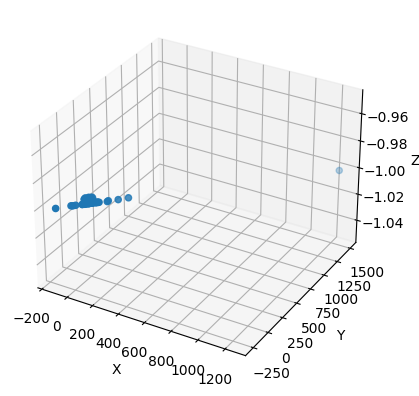

In [144]:
c2w=torch.tensor([[6.8935126e-01, 5.3373039e-01, -4.8982298e-01, -1.9745398e+00],
   [-7.2442728e-01 , 5.0788772e-01 ,-4.6610624e-01, -1.8789345e+00],
   [ 1.4901163e-08 , 6.7615211e-01 , 7.3676193e-01 , 2.9699826e+00],
   [ 0.0000000e+00 , 0.0000000e+00 , 0.0000000e+00 , 1.0000000e+00]])
origin=c2w[:3,-1].expand(points.shape)
location_in_mask=torch.sum((points-origin)[...,None,:]*(c2w[:3,:3].inverse()),dim=-1)
location_in_mask=-location_in_mask/location_in_mask[...,None,-1]

bx=plt.figure().add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
__ = bx.scatter(
      location_in_mask[...,0],
      location_in_mask[...,1],
      location_in_mask[...,2])
bx.set_xlabel('X')
bx.set_ylabel('Y')
bx.set_zlabel('Z')
plt.show()

In [103]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

(100, 100, 3)


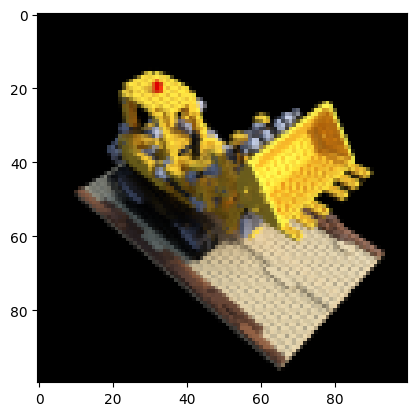

In [138]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

height, width = images.shape[1:3]

testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)

print(testimg.shape)

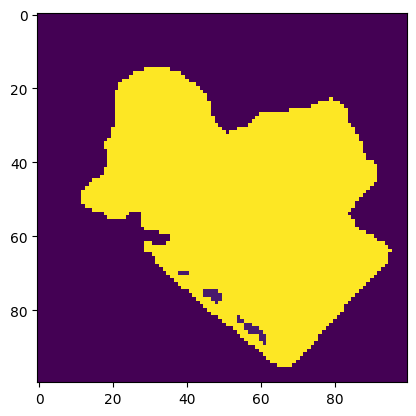

In [139]:
mask_result=np.load('test_img.npz')
mask_result=mask_result['result']
plt.imshow(mask_result)

In [140]:
def init_space(
    length: int,
    points_num: int
) -> torch.Tensor:
  r"""
  Initialize n^3 points in the space of length*length*length.
  """
  z, y, x = torch.meshgrid(
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32),
      torch.linspace(-length/2, length/2, points_num, dtype=torch.float32)
      )
  points = torch.stack(
      [x, -y, z],
      dim=-1
  )
  return points

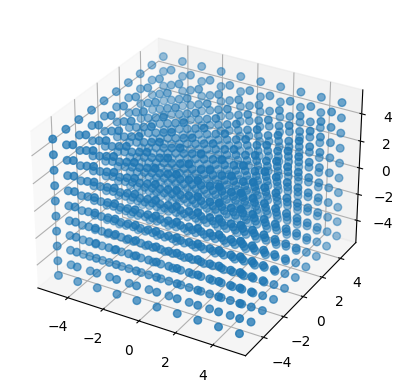

In [159]:
points = init_space(length=10, points_num=10)
ax=plt.figure().add_subplot(projection='3d')
ax.scatter(
      points[...,0],
      points[...,1],
      points[...,2],
      s=30
      )

In [150]:
def vote_building(
    c2w: torch.Tensor,
    points: torch.Tensor,
    mask_result: torch.Tensor,
    focal_length: float
) -> torch.Tensor:
  r"""
  Mapping spatial points to semantic matrices for voting on building categories
  """
  scores=[]
  origin = c2w[:3,-1].expand(points.shape)
  points_in_camera = torch.sum((points-origin)[..., None, :] * (c2w[:3, :3].inverse()), dim=-1)
  points_in_camera = -points_in_camera / points_in_camera[..., None, -1] * focal_length
  h, w = mask_result.shape
  points_in_camera = points_in_camera.reshape(-1, points.shape[-1])
  for point in points_in_camera:
    vote=0.0
    if((point[0] >= -w * .5) and (point[0] <= w * .5 - 1) and (point[1] >= -h * .5) and (point[1] <= h * .5 -1)):
      for x in [math.floor(point[0]), math.ceil(point[1])]:
        for y in [math.floor(point[1]), math.ceil(point[1])]:
          vote = max(mask_result[h//2-1-y][x+w//2], vote) 
    scores.append(torch.tensor(vote).unsqueeze_(dim=0))
  scores=torch.stack(scores, dim=0)
  scores=scores.reshape(points.shape[0], points.shape[1], points.shape[2], 1)
  return scores

<ipython-input-150-4244422c9898>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores.append(torch.tensor(vote).unsqueeze_(dim=0))


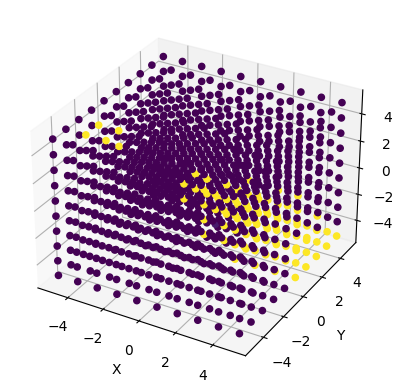

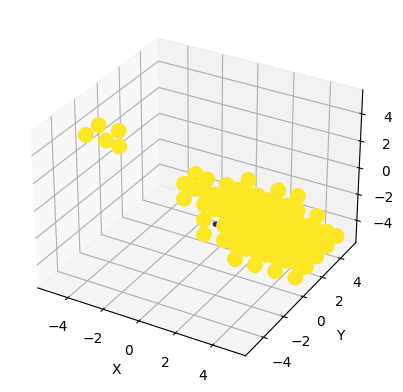

In [173]:
points = init_space(length=10, points_num=10)
scores = vote_building(c2w=torch.from_numpy(testpose), points=points, mask_result=torch.from_numpy(mask_result), focal_length=focal)
s=torch.ones_like(points)
ax=plt.figure().add_subplot(projection='3d')
_ = ax.scatter(
      points[...,0],
      points[...,1],
      points[...,2],
      s=20,
      c=scores,
      alpha = 1,
      )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
bx=plt.figure().add_subplot(projection='3d')
__ = bx.scatter(
      points[...,0],
      points[...,1],
      points[...,2],
      scores[...,0],
      scores[...,0],
      scores[...,0],
      alpha = 1,
      )
bx.set_xlabel('X')
bx.set_ylabel('Y')
bx.set_zlabel('Z')
plt.show()